In [1]:
import pandas as pd
import numpy as np
import itertools as it
import matplotlib.pyplot as plt
from matplotlib.pylab import rc, plot
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import precision_recall_curve, classification_report, confusion_matrix, roc_curve
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv('telecom_churn.csv')

In [3]:
df.sample(5)

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
199,DC,63,408,399-6786,no,no,0,83.0,64,14.11,...,106,15.05,245.7,89,11.06,13.0,3,3.51,0,False
326,AL,121,408,331-8909,no,yes,35,68.7,95,11.68,...,69,17.78,197.4,42,8.88,11.4,4,3.08,1,False
636,KS,121,408,373-5438,no,no,0,150.7,105,25.62,...,133,16.77,169.0,116,7.61,9.2,15,2.48,1,False
628,VT,97,415,328-2236,no,no,0,112.7,119,19.16,...,109,18.50,152.1,76,6.84,6.5,5,1.76,1,False
2793,VA,107,510,330-2662,no,yes,27,283.4,104,48.18,...,152,19.05,241.3,63,10.86,14.4,7,3.89,2,False


### Предобработка данных

In [4]:
d = {'yes' : 1, 'no' : 0}

df['international plan'] = df['international plan'].map(d)
df['voice mail plan'] = df['voice mail plan'].map(d)
df['churn'] = df['churn'].astype('int64')

le = LabelEncoder()
df['state'] = le.fit_transform(df['state'])

ohe = OneHotEncoder(sparse=False)

encoded_state = ohe.fit_transform(df['state'].values.reshape(-1, 1))
tmp = pd.DataFrame(encoded_state, columns=['state ' + str(i) for i in range(encoded_state.shape[1])])
df = pd.concat([df, tmp], axis=1)

In [5]:
df.sample(10)

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,state 41,state 42,state 43,state 44,state 45,state 46,state 47,state 48,state 49,state 50
830,5,121,408,409-4447,1,0,0,167.7,94,28.51,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
452,41,91,510,327-3850,0,0,0,149.0,115,25.33,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2163,16,119,415,384-4595,0,0,0,231.5,82,39.36,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1759,43,66,415,402-3886,0,1,35,190.8,100,32.44,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3295,42,110,415,391-5516,0,0,0,227.7,88,38.71,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2537,27,122,415,396-8662,0,0,0,215.6,86,36.65,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2165,24,160,415,347-5063,0,0,0,171.2,103,29.10,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
89,31,128,415,358-9095,0,0,0,237.9,125,40.44,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1211,28,94,408,408-9463,0,0,0,174.0,85,29.58,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
956,2,77,415,408-3610,0,1,23,209.7,73,35.65,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 72 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   3333 non-null   int32  
 1   account length          3333 non-null   int64  
 2   area code               3333 non-null   int64  
 3   phone number            3333 non-null   object 
 4   international plan      3333 non-null   int64  
 5   voice mail plan         3333 non-null   int64  
 6   number vmail messages   3333 non-null   int64  
 7   total day minutes       3333 non-null   float64
 8   total day calls         3333 non-null   int64  
 9   total day charge        3333 non-null   float64
 10  total eve minutes       3333 non-null   float64
 11  total eve calls         3333 non-null   int64  
 12  total eve charge        3333 non-null   float64
 13  total night minutes     3333 non-null   float64
 14  total night calls       3333 non-null   

In [7]:
df['churn'].value_counts()

0    2850
1     483
Name: churn, dtype: int64

### Обучим модель

In [8]:
X = df.drop(['churn', 'phone number'], axis=1)
y = df['churn']

# Делим выборку на train и test, все метрики будем оценивать на тестовом датасете

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,  test_size=0.33, random_state=42)

# Обучаем ставшую родной логистическую регрессию

lr = LogisticRegression(random_state=42, max_iter=10000)
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [9]:
len(y), len(df), len(y_test)

(3333, 3333, 1100)

In [10]:
y_test.value_counts()

0    941
1    159
Name: churn, dtype: int64

In [11]:
y_predicted = lr.predict(X_test)

In [12]:
len(y_predicted), sum(y_predicted)

(1100, 71)

### функция для построения матрицы ошибок

In [13]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in it.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[915  26]
 [114  45]]


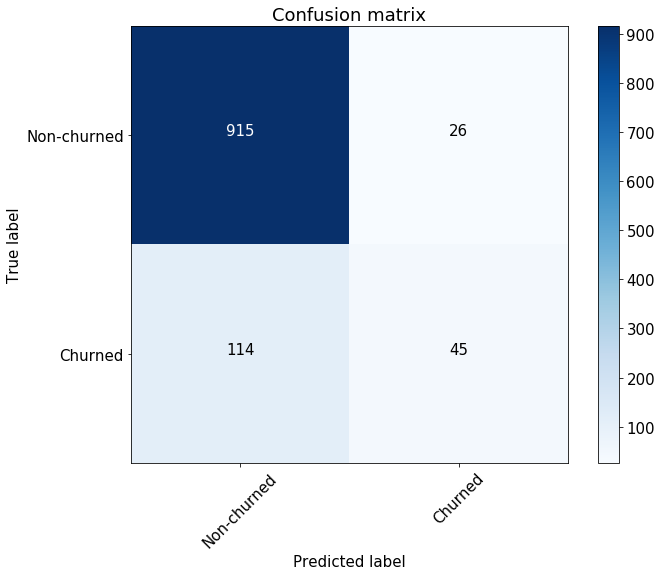

In [14]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, y_predicted)
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-churned', 'Churned'], title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [15]:
report = classification_report(y_test, lr.predict(X_test), target_names=['Non-churned', 'Churned'])
print(report)

              precision    recall  f1-score   support

 Non-churned       0.89      0.97      0.93       941
     Churned       0.63      0.28      0.39       159

    accuracy                           0.87      1100
   macro avg       0.76      0.63      0.66      1100
weighted avg       0.85      0.87      0.85      1100



### ROC - кривая

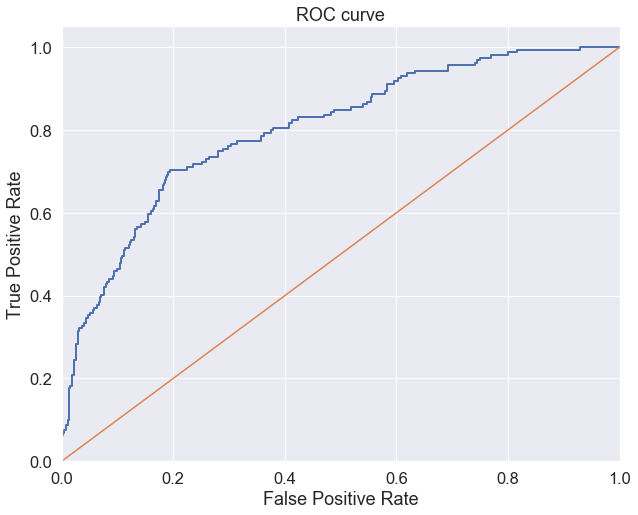

In [18]:
sns.set(font_scale=1.5)
sns.set_color_codes("muted")

plt.figure(figsize=(10, 8))
fpr, tpr, thresholds = roc_curve(y_test, lr.predict_proba(X_test)[:,1], pos_label=1)
plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.savefig("ROC.png")
plt.show()

### Precision-Recall curve

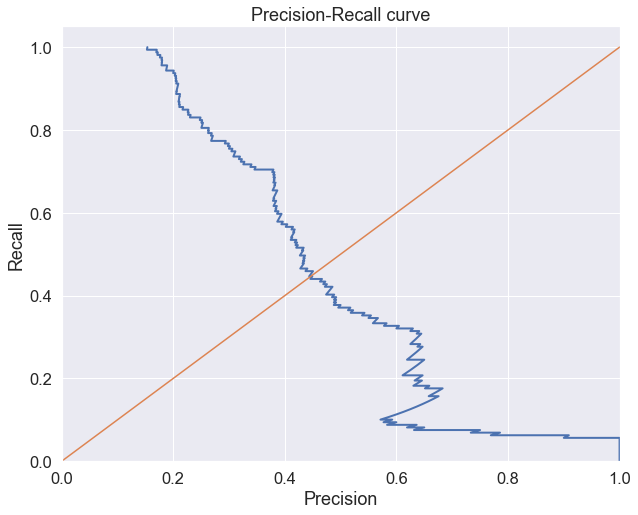

In [23]:
sns.set(font_scale=1.5)
sns.set_color_codes("muted")

plt.figure(figsize=(10, 8))
fpr, tpr, thresholds = precision_recall_curve(y_test, lr.predict_proba(X_test)[:,1], pos_label=1)
plt.plot(fpr, tpr, lw=lw, label='Precision-Recall curve')
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.title('Precision-Recall curve')
plt.savefig("Precision-Recall.png")
plt.show()

### Logistic Loss

In [24]:
def logloss_crutch(y_true, y_pred, eps=1e-15):
    return - (y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

In [27]:
print('Logloss при неуверенной классификации %f' % logloss_crutch(1, 0.5))

print('Logloss при уверенной классификации и верном ответе %f' % logloss_crutch(1, 0.9))

print('Logloss при уверенной классификации и НЕверном негативном ответе ответе %f' % logloss_crutch(1, 0.1))

print('Logloss при уверенной классификации и НЕверном позитивном ответе %f' % logloss_crutch(0, 0.9))

Logloss при неуверенной классификации 0.693147
Logloss при уверенной классификации и верном ответе 0.105361
Logloss при уверенной классификации и НЕверном негативном ответе ответе 2.302585
Logloss при уверенной классификации и НЕверном позитивном ответе 2.302585
